<div align="center">

# 🌳 Project 2: Decision Tree Classifier


### 👥 Group Members

| 🆔 MSSV    | 👨‍🎓 Họ và Tên           |
|-----------|--------------------------|
| 22120194  | Nguyễn Nhật Long         |
| 22120197  | Nguyễn Vĩnh Lương        |
| 22120238  | Nguyễn Minh Nguyên       |
| 22120252  | Giang Đức Nhật           |

### ♥️ Dataset 02: Palmer Penguins
</div>

## **0. Requirements**

### **0.1 Packages**

In [ ]:
%pip install pandas numpy seaborn matplotlib pydataset scikit-learn graphviz

### **0.2. Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.impute import SimpleImputer

## **1. Preparing Dataset**

### **1.1. Load dataset**

In [2]:
df_raw = sns.load_dataset('penguins')
print("Data loaded successfully.")

features = df_raw.drop(columns=['species'])
target = df_raw['species']
feature_names = features.columns.tolist()
class_names = target.unique().tolist()

Data loaded successfully.


### **1.2. Define Pipeline**

In [3]:
# Explore Data (Summary)
df_raw.info()
df_cleaned = df_raw.dropna().reset_index(drop=True)
print(f"\nShape after dropping rows with any missing values: {df_cleaned.shape}")

# Separate features (X) and target (y) from the RAW cleaned data
y = df_cleaned['species']
X = df_cleaned.drop('species', axis=1)
class_names = sorted(y.unique().tolist())

# Define column types for the preprocessor
nominal_cols = ['island', 'sex']
numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']



preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), nominal_cols)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Function to create the full model pipeline
def build_model_pipeline(max_depth=None):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42))
    ])
    
print("Model pipeline defined successfully.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB

Shape after dropping rows with any missing values: (333, 7)
Model pipeline defined successfully.


### **1.3. Train/Test Splits**

In [4]:
subsets = []
split_ratios = [0.4, 0.6, 0.8, 0.9]
for train_size in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=42, stratify=y
    )
    subsets.append({
        'train_size': train_size,
        'feature_train': X_train,
        'label_train': y_train,
        'feature_test': X_test,
        'label_test': y_test
    })
print(f"Created {len(subsets)} data subsets.")

Created 4 data subsets.


### **1.4. Visualization**

#### 1.4.1. Original Dataset Class Distribution

This cell defines the location for saving the distribution plots.
Distribution plots will be saved to: c:\Users\Nhat\Desktop\ai.decision_tree\Dataset 02\Distribution


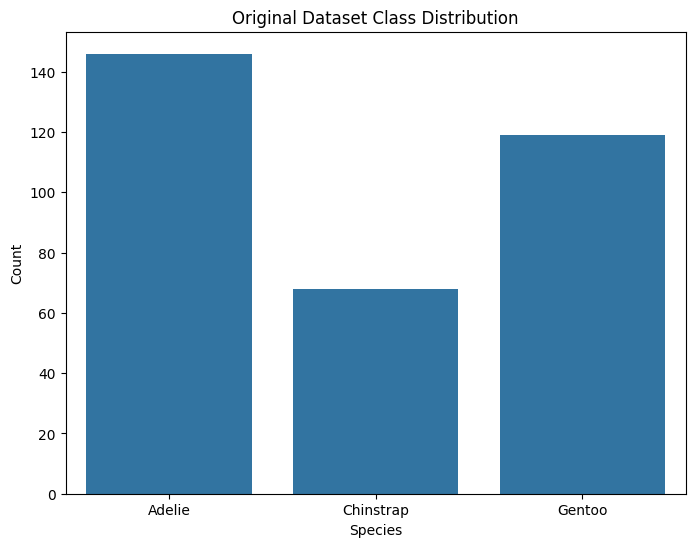

Saved original distribution plot.


In [5]:
print("This cell defines the location for saving the distribution plots.")
output_dir_dist = "Dataset 02/Distribution"
os.makedirs(output_dir_dist, exist_ok=True)
print(f"Distribution plots will be saved to: {os.path.abspath(output_dir_dist)}")
plt.figure(figsize=(8, 6))
sns.countplot(x=y, order=class_names)
plt.title('Original Dataset Class Distribution')
plt.xlabel('Species')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir_dist, 'original_distribution.png'))
plt.show()
print(f"Saved original distribution plot.")

#### 1.4.2. Split Dataset Class Distribution

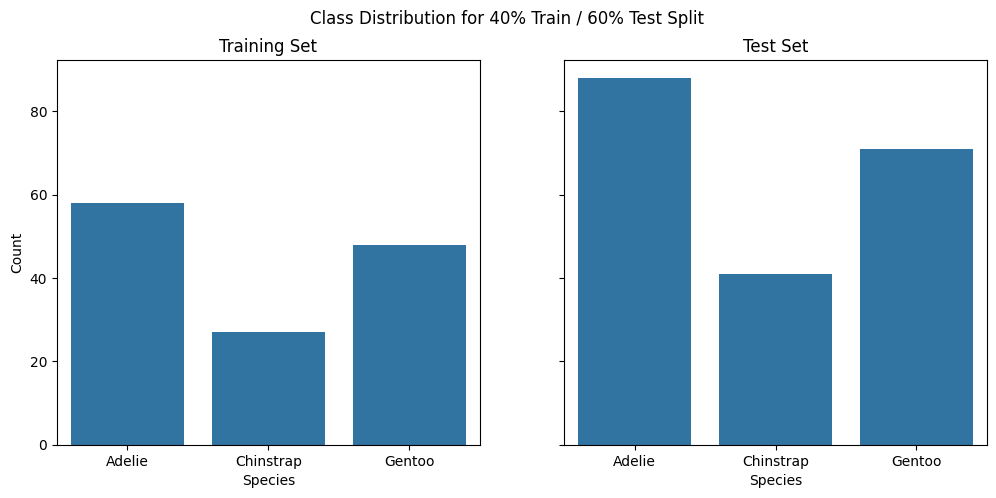

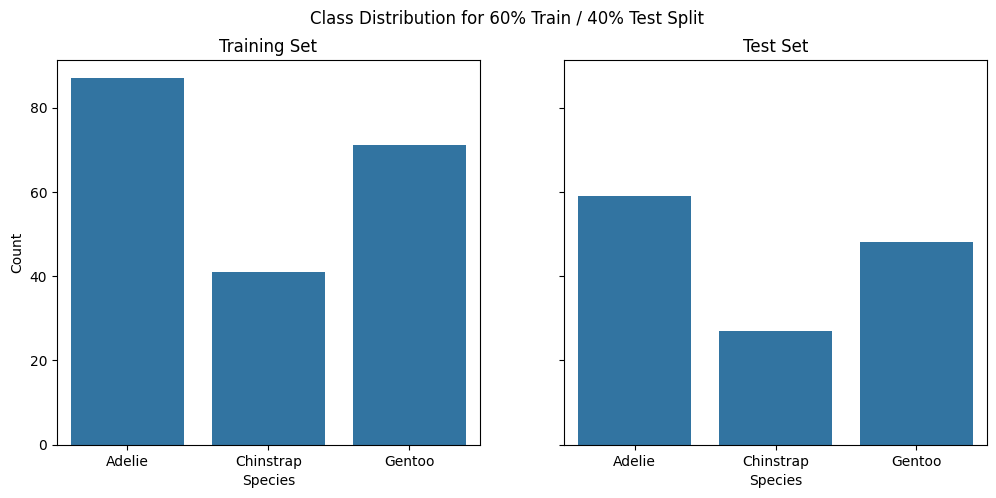

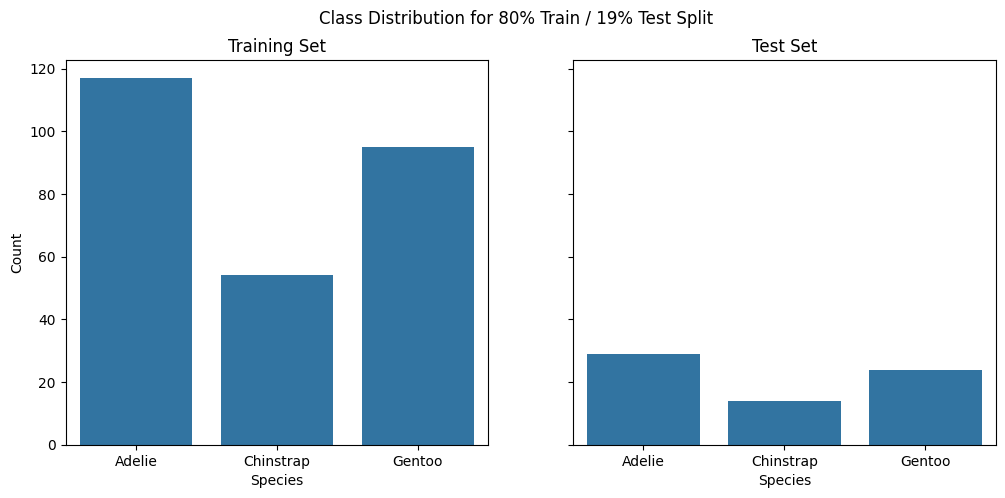

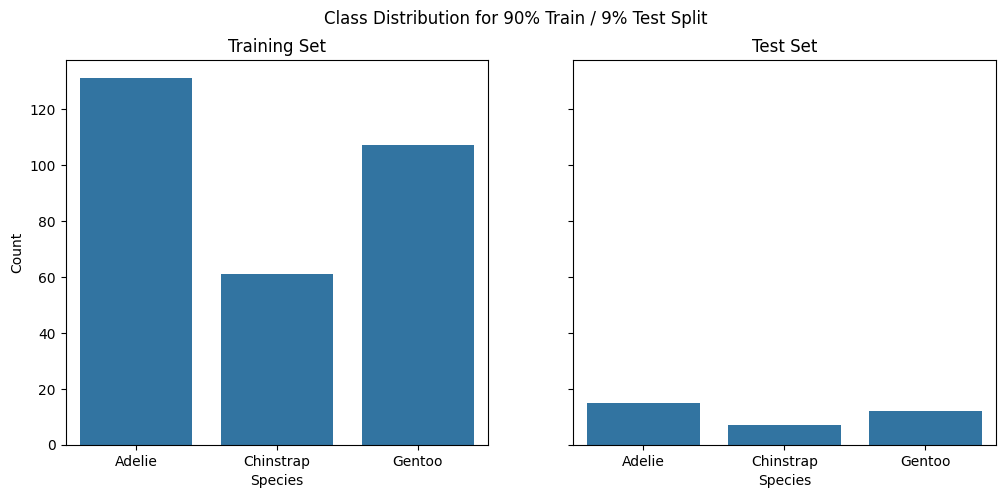

Saved split distribution plots.


In [6]:
for subset in subsets:
    train_size = subset['train_size']
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f'Class Distribution for {int(train_size*100)}% Train / {int((1-train_size)*100)}% Test Split')
    sns.countplot(ax=axes[0], x=subset['label_train'], order=class_names).set_title('Training Set')
    axes[0].set_xlabel('Species'); axes[0].set_ylabel('Count')
    sns.countplot(ax=axes[1], x=subset['label_test'], order=class_names).set_title('Test Set')
    axes[1].set_xlabel('Species'); axes[1].set_ylabel('')
    plt.savefig(os.path.join(output_dir_dist, f'split_distribution_{int(train_size*100)}.png'))
    plt.show()
print(f"Saved split distribution plots.")

## **2. Implementing Decision Tree**

### **2.1. Train model for splits**

In [7]:
trained_pipelines = [] # Store the trained pipelines

for train_size in split_ratios:
    print(f"\n================== TRAINING FOR SPLIT: {int(train_size*100)}% TRAIN ==================")
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42, stratify=y)
    
    # Build and train the entire pipeline
    model_pipeline = build_model_pipeline(max_depth=4) # Fixed depth = 4 for visualization
    model_pipeline.fit(X_train, y_train)
    trained_pipelines.append({'pipeline': model_pipeline, 'X_test': X_test, 'y_test': y_test, 'train_size': train_size})

print(f"\nSuccessfully trained {len(trained_pipelines)} models using pipelines.")


================== TRAINING FOR SPLIT: 40% TRAIN ==================

================== TRAINING FOR SPLIT: 60% TRAIN ==================

================== TRAINING FOR SPLIT: 80% TRAIN ==================

================== TRAINING FOR SPLIT: 90% TRAIN ==================

Successfully trained 4 models using pipelines.


### **2.2. Visualization**

#### 2.2.1. Visualizing decision trees

Decision tree files will be saved to: c:\Users\Nhat\Desktop\ai.decision_tree\Dataset 02\Decision_Tree

PROCESSING SPLIT: 40_60
Decision Tree Visualization (Split 40_60)


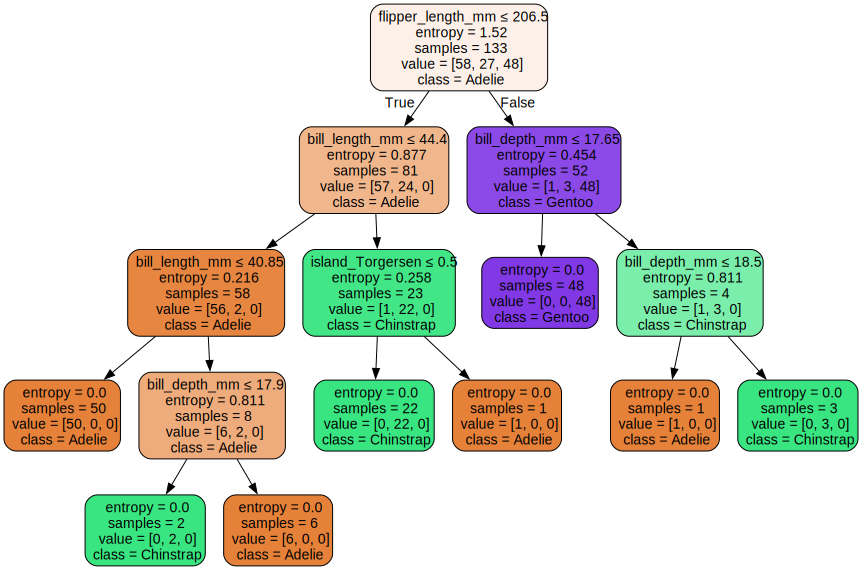

Saved tree image to: Dataset 02/Decision_Tree\tree_split_40_60.png
--------------------------------------------------

PROCESSING SPLIT: 60_40
Decision Tree Visualization (Split 60_40)


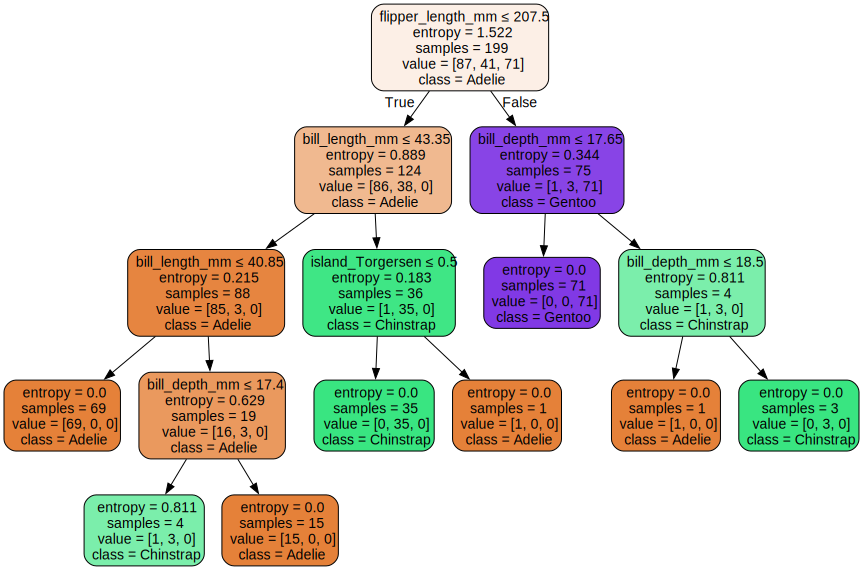

Saved tree image to: Dataset 02/Decision_Tree\tree_split_60_40.png
--------------------------------------------------

PROCESSING SPLIT: 80_20
Decision Tree Visualization (Split 80_20)


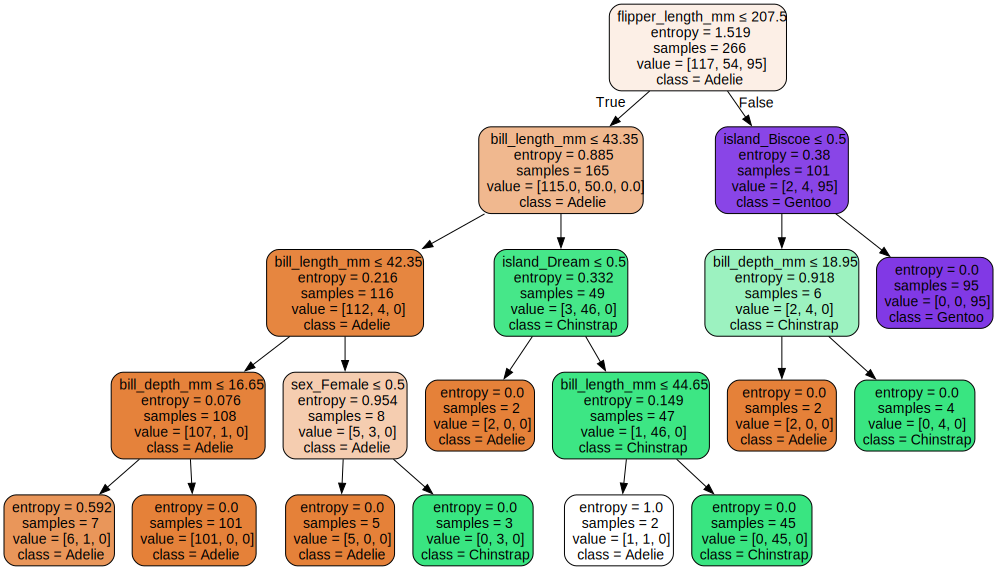

Saved tree image to: Dataset 02/Decision_Tree\tree_split_80_20.png
--------------------------------------------------

PROCESSING SPLIT: 90_10
Decision Tree Visualization (Split 90_10)


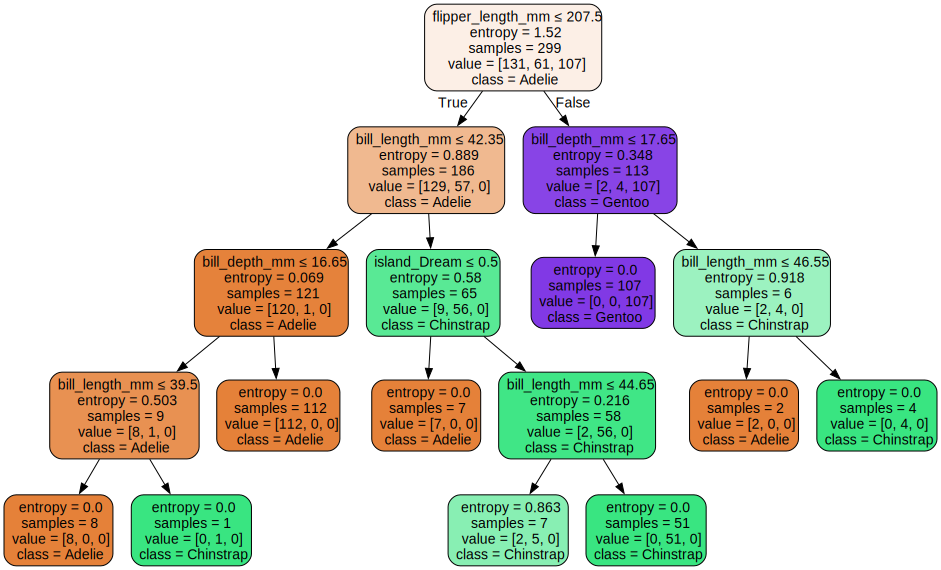

Saved tree image to: Dataset 02/Decision_Tree\tree_split_90_10.png
--------------------------------------------------


In [8]:
output_dir_trees = "Dataset 02/Decision_Tree"
os.makedirs(output_dir_trees, exist_ok=True)
print(f"Decision tree files will be saved to: {os.path.abspath(output_dir_trees)}")

# Loop through each data subset
for i, subset in enumerate(subsets):
    train_size = subset['train_size']
    ratio_name = f"{int(train_size*100)}_{round((1-train_size)*100)}"
    print(f"\nPROCESSING SPLIT: {ratio_name}")
    
    # Train Model
    model_pipeline = build_model_pipeline(max_depth=4) # Fixed depth for visualization
    model_pipeline.fit(subset['feature_train'], subset['label_train'])
    
    
    # Visualization 
    print(f"Decision Tree Visualization (Split {ratio_name})")
    feature_names_processed = numerical_cols + model_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(nominal_cols).tolist()
    tree_model = model_pipeline.named_steps['classifier']
    
    dot_data = export_graphviz(
        tree_model,
        out_file=None, 
        feature_names=feature_names_processed,
        class_names=class_names, 
        filled=True, 
        rounded=True, 
        special_characters=True
    )
    
    graph = graphviz.Source(dot_data)
    display(graph)
    

    image_filepath = os.path.join(output_dir_trees, f'tree_split_{ratio_name}')
    try:
        graph.render(image_filepath, format='png', cleanup=True)
        print(f"Saved tree image to: {image_filepath}.png")
    except graphviz.backend.execute.ExecutableNotFound:
        print("\n---")
        print("WARNING: Graphviz executable not found on your system's PATH.")
        print("The tree image could not be saved to a file, but it is displayed above.")
        print("To save images, please install Graphviz and add it to your system's PATH.")
        print("---")

    print("-" * 50)

## **3. Evaluating Decision Trees**

Decision tree files will be saved to: c:\Users\Nhat\Desktop\Dataset02\Evaluation

 PROCESSING SPLIT: 40_60
------ Classification Report ------
              precision    recall  f1-score   support

      Adelie       0.99      0.93      0.96        88
   Chinstrap       0.85      0.98      0.91        41
      Gentoo       1.00      0.99      0.99        71

    accuracy                           0.96       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.96      0.96       200


------ Confusion Matrix ------
Saved confusion matrix plot to: Dataset02/Evaluation\confusion_matrix_40_60.png


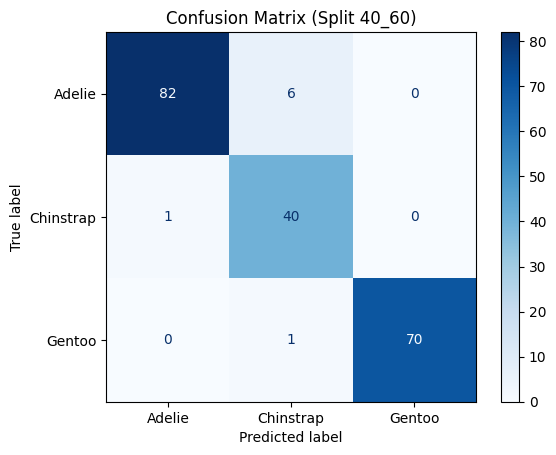


 PROCESSING SPLIT: 60_40
------ Classification Report ------
              precision    recall  f1-score   support

      Adelie       1.00      0.95      0.97        59
   Chinstrap       0.84      1.00      0.92        27
      Gentoo       1.00      0.96      0.98        48

    accuracy                           0.96       134
   macro avg       0.95      0.97      0.96       134
weighted avg       0.97      0.96      0.96       134


------ Confusion Matrix ------
Saved confusion matrix plot to: Dataset02/Evaluation\confusion_matrix_60_40.png


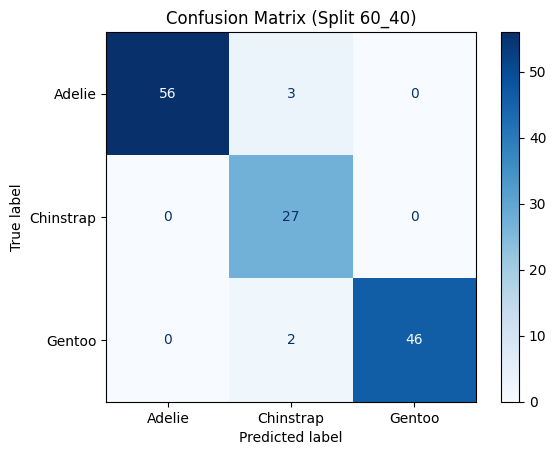


 PROCESSING SPLIT: 80_20
------ Classification Report ------
              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        29
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      0.92      0.96        24

    accuracy                           0.97        67
   macro avg       0.98      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67


------ Confusion Matrix ------
Saved confusion matrix plot to: Dataset02/Evaluation\confusion_matrix_80_20.png


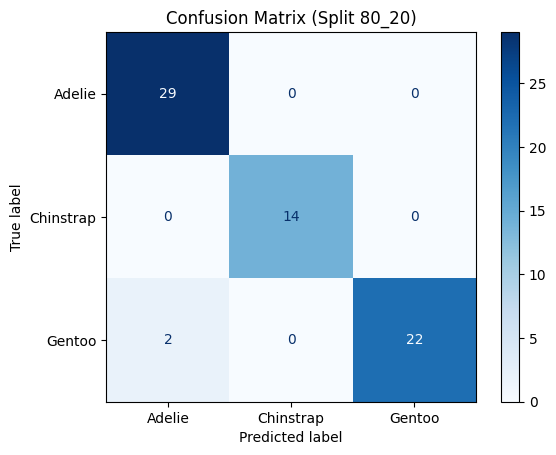


 PROCESSING SPLIT: 90_10
------ Classification Report ------
              precision    recall  f1-score   support

      Adelie       0.88      1.00      0.94        15
   Chinstrap       1.00      1.00      1.00         7
      Gentoo       1.00      0.83      0.91        12

    accuracy                           0.94        34
   macro avg       0.96      0.94      0.95        34
weighted avg       0.95      0.94      0.94        34


------ Confusion Matrix ------
Saved confusion matrix plot to: Dataset02/Evaluation\confusion_matrix_90_10.png


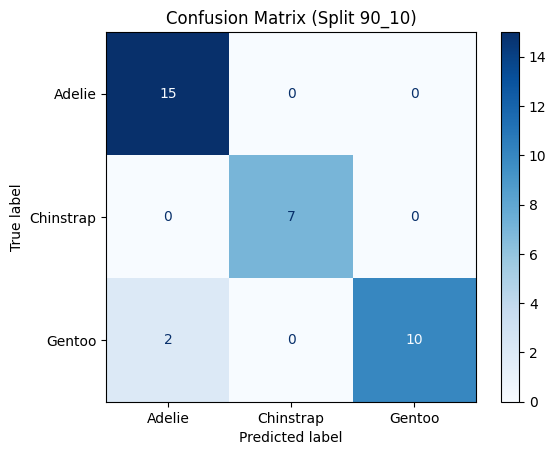

In [ ]:
output_evaluation = "Dataset 02/Evaluation"
os.makedirs(output_evaluation, exist_ok=True)
print(f"Decision tree files will be saved to: {os.path.abspath(output_evaluation)}")

# Loop through each data subset
for i, subset in enumerate(subsets):
    train_size = subset['train_size']
    ratio_name = f"{int(train_size*100)}_{round((1-train_size)*100)}"
    print(f"\n PROCESSING SPLIT: {ratio_name}") 
    
    # --- 2.2.1. Train Model ---
    model_pipeline = build_model_pipeline(max_depth=4) # Fixed depth for visualization
    model_pipeline.fit(subset['feature_train'], subset['label_train'])
    
    # --- 2.3. Evaluate Decision Tree ---
    y_pred = model_pipeline.predict(subset['feature_test'])
    print("------ Classification Report ------")
    print(classification_report(subset['label_test'], y_pred, target_names=class_names))
    
    print("\n------ Confusion Matrix ------")
    cm = confusion_matrix(subset['label_test'], y_pred, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix (Split {ratio_name})")
    # Save the figure BEFORE showing it
    cm_filepath = os.path.join(output_evaluation, f'confusion_matrix_{ratio_name}.png')
    plt.savefig(cm_filepath)
    print(f"Saved confusion matrix plot to: {cm_filepath}")
    
    plt.show()


## **4. Depth and Accuracy of a Decision Tree** 

Depth analysis tree visualizations will be saved to: c:\Users\Nhat\Desktop\ai.decision_tree\Dataset 02\Depth_Analysis_Trees

--- Processing for max_depth = None ---


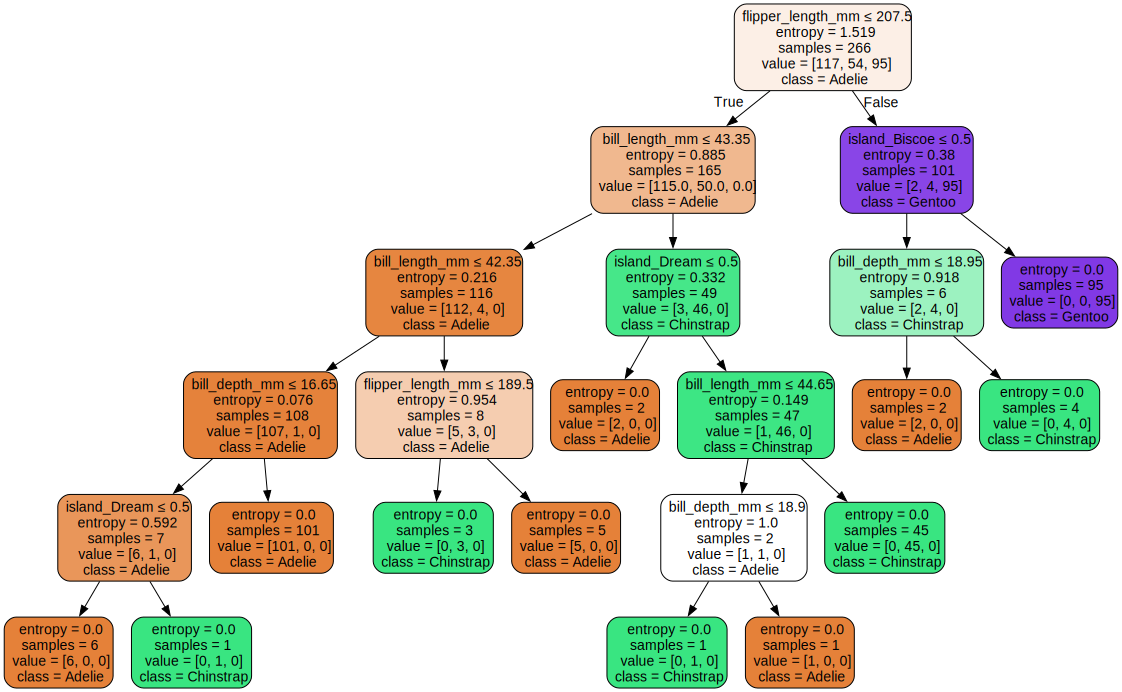

Saved tree image to: Dataset 02/Depth_Analysis_Trees\tree_depth_None.png

--- Processing for max_depth = 2 ---


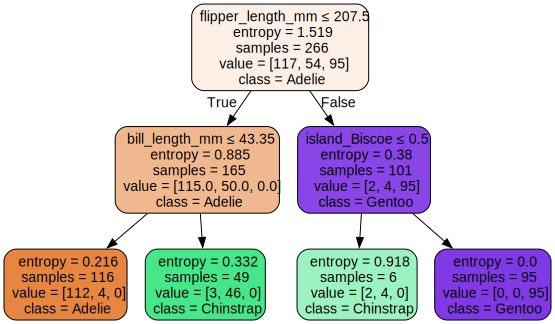

Saved tree image to: Dataset 02/Depth_Analysis_Trees\tree_depth_2.png

--- Processing for max_depth = 3 ---


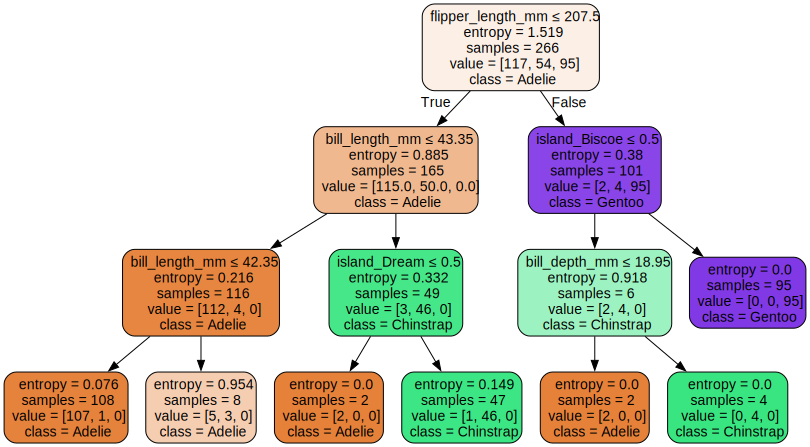

Saved tree image to: Dataset 02/Depth_Analysis_Trees\tree_depth_3.png

--- Processing for max_depth = 4 ---


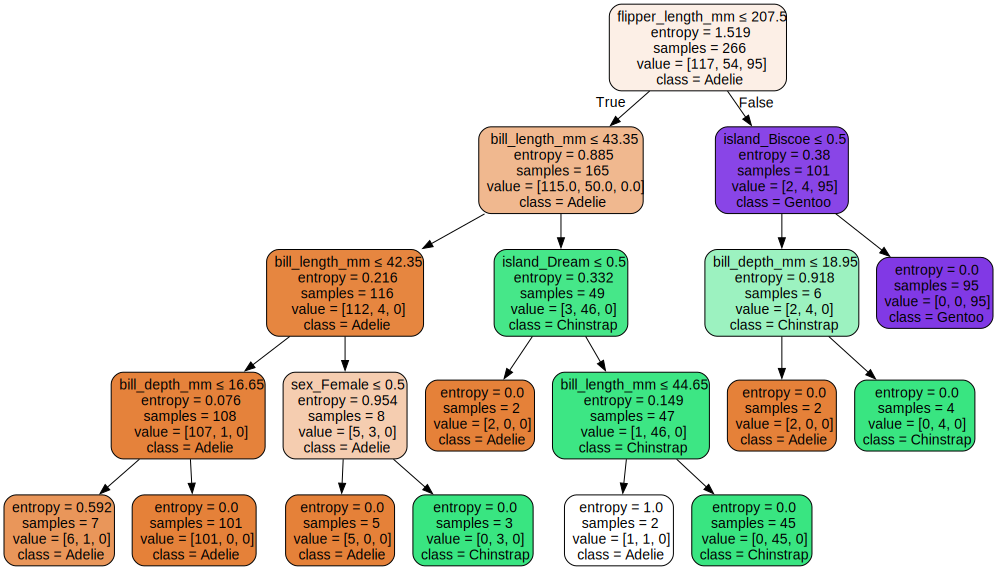

Saved tree image to: Dataset 02/Depth_Analysis_Trees\tree_depth_4.png

--- Processing for max_depth = 5 ---


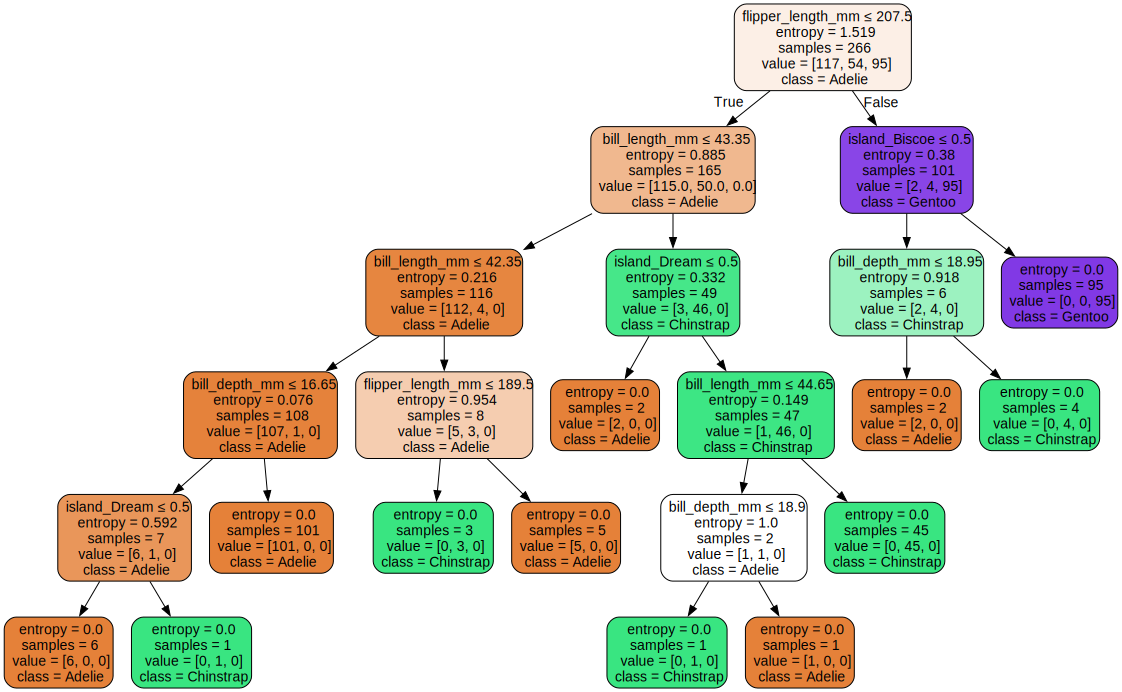

Saved tree image to: Dataset 02/Depth_Analysis_Trees\tree_depth_5.png

--- Processing for max_depth = 6 ---


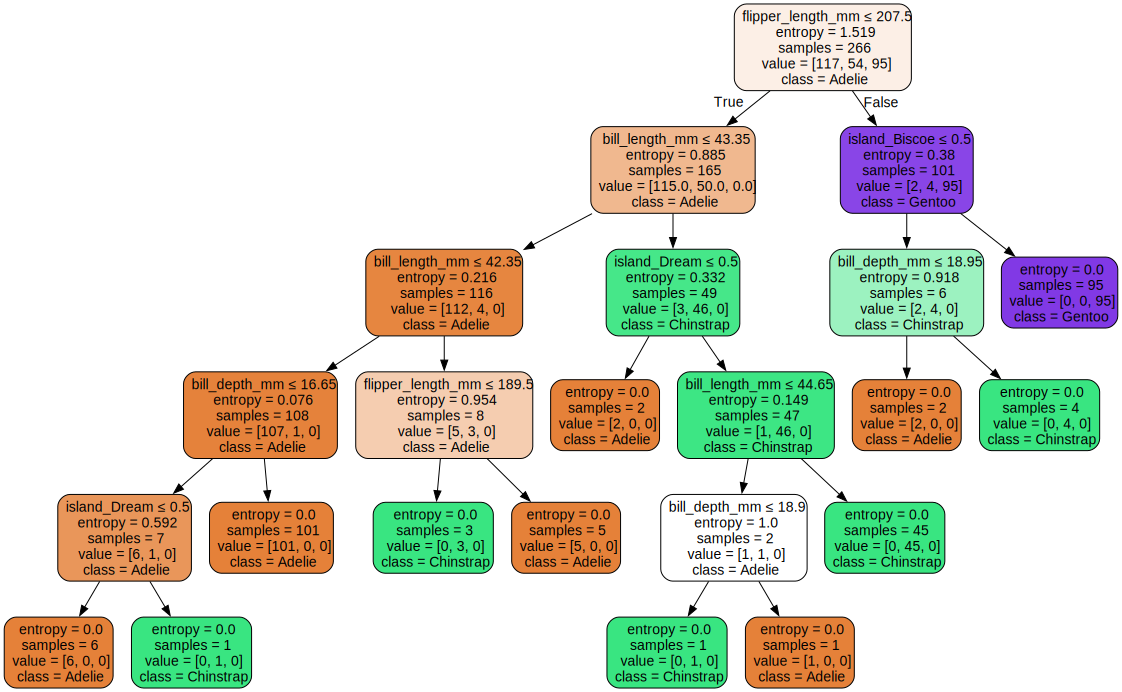

Saved tree image to: Dataset 02/Depth_Analysis_Trees\tree_depth_6.png

--- Processing for max_depth = 7 ---


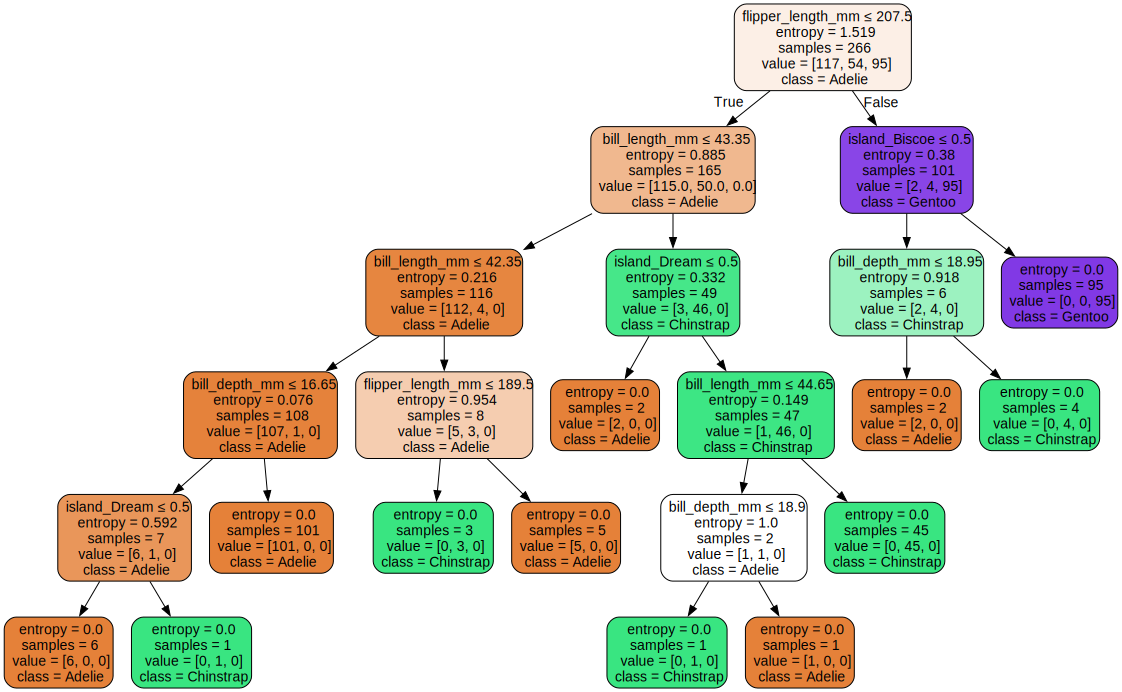

Saved tree image to: Dataset 02/Depth_Analysis_Trees\tree_depth_7.png

------ Accuracy by Max Depth Table ------
  max_depth  Accuracy
0      None  0.925373
1         2  0.940299
2         3  0.955224
3         4  0.970149
4         5  0.925373
5         6  0.925373
6         7  0.925373


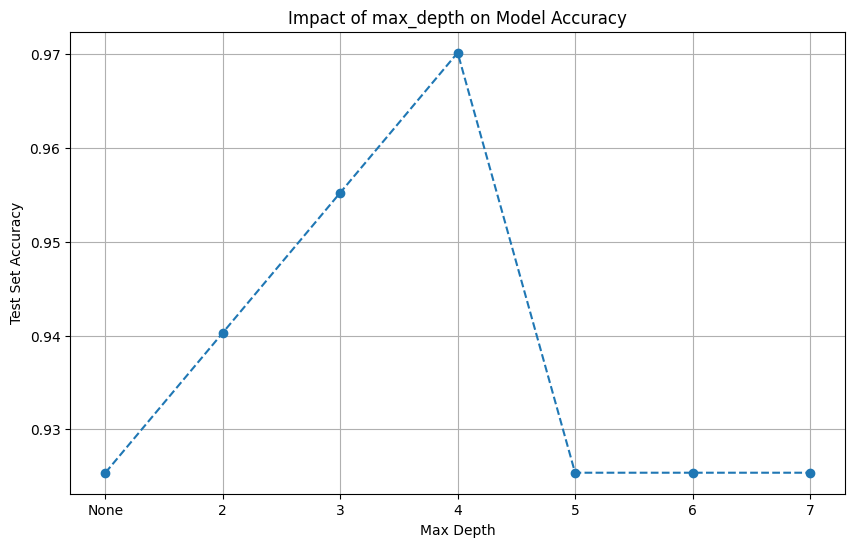

In [11]:
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

depths = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = []
depth_labels = []

# UPDATED: Create a specific directory for the depth analysis trees
output_dir_depth_trees = "Dataset 02/Depth_Analysis_Trees"
os.makedirs(output_dir_depth_trees, exist_ok=True)
print(f"Depth analysis tree visualizations will be saved to: {os.path.abspath(output_dir_depth_trees)}")

for depth in depths:
    depth_str = 'None' if depth is None else str(depth)
    print(f"\n--- Processing for max_depth = {depth_str} ---")
    
    model_pipeline_depth = build_model_pipeline(max_depth=depth)
    model_pipeline_depth.fit(X_train_80, y_train_80)
    y_pred_depth = model_pipeline_depth.predict(X_test_80)
    accuracy = accuracy_score(y_test_80, y_pred_depth)
    
    accuracy_results.append(accuracy)
    depth_labels.append(depth_str)
    
    # --- Visualization for each depth ---
    feature_names_processed_depth = numerical_cols + model_pipeline_depth.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(nominal_cols).tolist()
    tree_model_depth = model_pipeline_depth.named_steps['classifier']
    
    dot_data_depth = export_graphviz(
        tree_model_depth,
        out_file=None, 
        feature_names=feature_names_processed_depth,
        class_names=class_names, 
        filled=True, 
        rounded=True, 
        special_characters=True
    )
    
    graph_depth = graphviz.Source(dot_data_depth)
    display(graph_depth)
    
    # Save the tree image for this specific depth
    image_filepath_depth = os.path.join(output_dir_depth_trees, f'tree_depth_{depth_str}')
    try:
        graph_depth.render(image_filepath_depth, format='png', cleanup=True)
        print(f"Saved tree image to: {image_filepath_depth}.png")
    except graphviz.backend.execute.ExecutableNotFound:
        print("WARNING: Graphviz executable not found. Could not save tree image.")

results_df = pd.DataFrame({'max_depth': depth_labels, 'Accuracy': accuracy_results})
print("\n------ Accuracy by Max Depth Table ------")
print(results_df)

plt.figure(figsize=(10, 6))
plt.plot(results_df['max_depth'], results_df['Accuracy'], marker='o', linestyle='--')
plt.title('Impact of max_depth on Model Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Test Set Accuracy')
plt.grid(True)
plt.savefig(os.path.join(output_dir_depth_trees, 'depth_vs_accuracy.png'))
plt.show()
